In [1]:
import numpy as np
import os
from os.path import join as pjoin
from glob import iglob
from shutil import copyfile

In [2]:
root_path = '/data/ksb'
bert_root = pjoin(root_path, 'BertSum/kor_PreSumm')
kobart_root = pjoin(root_path, 'BART/KoBART-summarization')
refsum_root = pjoin(root_path, 'RefSum/Refactoring-Summarization')

In [3]:
data_root = pjoin(root_path, 'korean_document')

In [4]:
kobert_root = pjoin(root_path, 'BertSum/koBertSum')
kobert_data = pjoin(kobert_root, 'ko_raw_stories')
kobert_data

'/data/ksb/BertSum/koBertSum/ko_raw_stories'

In [5]:
def mkdir_p(path):
    import errno
    try:
        os.makedirs(path)
    except OSError as err:
        if err.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
            
def del_folder(path):
    try:
        rmtree(path)
    except:
        pass

In [6]:
def get_article_list(path):
    
    article_list = []
    
    with jsonlines.open(path) as reader:
        for news in reader:
            content = news['article_original']
            idx = news['id']
            abs_summ = news['abstractive']
            ext_summ = news['extractive']

            article = (idx, content, abs_summ, ext_summ)
            article_list.append(article)
        
    return article_list
    

In [7]:
import jsonlines

train_data = pjoin(data_root, 'train.jsonl')
val_data = pjoin(data_root, 'vaild.jsonl')

train_article_list = get_article_list(train_data)
val_article_list = get_article_list(val_data)

(len(train_article_list), len(val_article_list))

(260697, 10000)

### BERT Extractor

### korBART Finetuning data


In [9]:
kor_bart_data_dir = pjoin(kobart_root, 'data')

train_data_path = pjoin(kor_bart_data_dir, 'train.tsv')
test_data_path = pjoin(kor_bart_data_dir, 'test.tsv')

In [11]:
from kobart import get_kobart_tokenizer
kobart_tokenizer = get_kobart_tokenizer()

train_dataset = []
for data in train_article_list:
    news_id = data[0]
    news = data[1]
    summary = data[2]
    
    news_token = []
    for sent in news:
        news_token += kobart_tokenizer.tokenize(sent)
        
    summary_token = kobart_tokenizer.tokenize(summary)
    
    train_dataset.append((news_id, news, summary, news_token, summary_token))


using cached model


In [12]:
kobart_tokenizer = get_kobart_tokenizer()

val_dataset = []
for data in val_article_list:
    news_id = data[0]
    news = data[1]
    summary = data[2]
    
    news_token = []
    for sent in news:
        news_token += kobart_tokenizer.tokenize(sent)
        
    summary_token = kobart_tokenizer.tokenize(summary)
    
    val_dataset.append((news_id, news, summary, news_token, summary_token))

len(val_dataset)

using cached model


10000

In [13]:
(len(train_dataset), len(val_dataset))

(260697, 10000)

In [14]:
dataset = train_dataset + val_dataset
len(dataset)

270697

In [15]:
article_token_dist = [len(data[-2]) for data in dataset]
summary_token_dist = [len(data[-1]) for data in dataset]

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


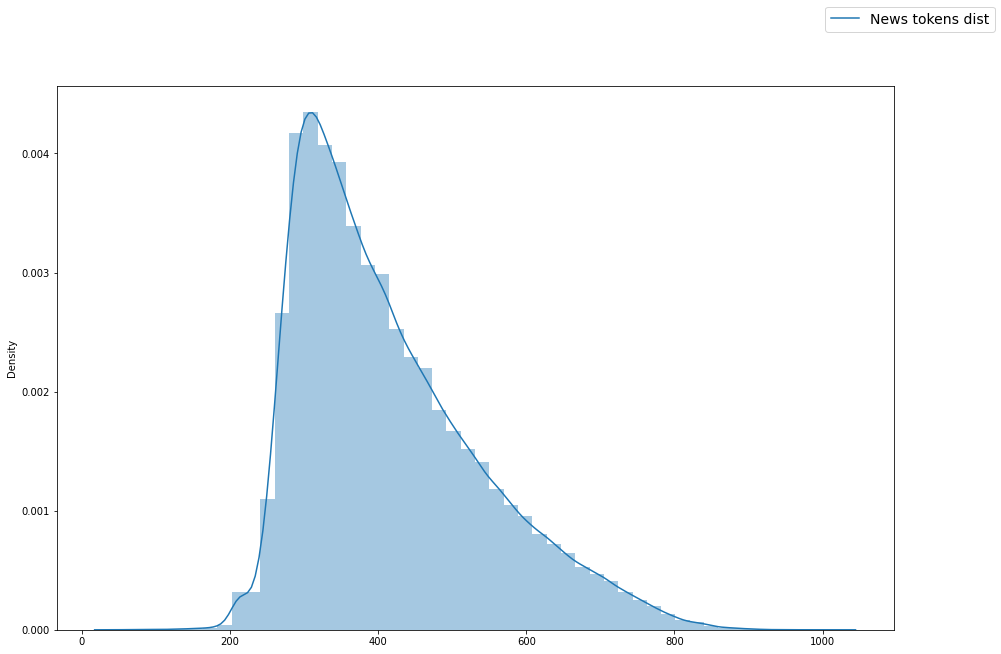

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,10))

sns.distplot(article_token_dist)
fig.legend(labels=['News tokens dist'], fontsize=14)
plt.show()

Token Distribution : 3.8918202981106265 ~ 6.922643891475888
Token Distribution Mean : 5.989

Variance : 0.08 
Standard Devidation: 0.28

95% Confidence Interval : 376.52 ~ 421.00
99% Confidence Interval : 369.93 ~ 428.51


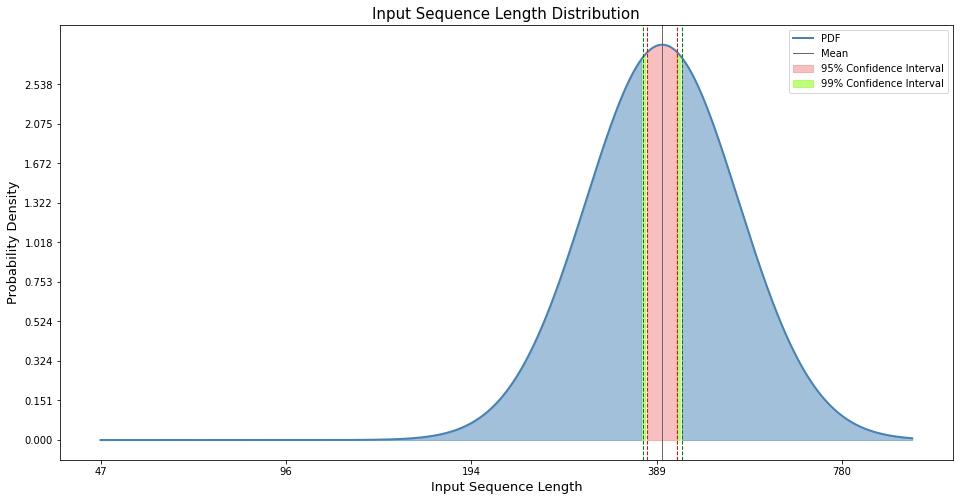

In [17]:
import scipy.stats as stats

plt.rcParams["figure.figsize"] = (16,8)

log_tok_dist = np.log1p(article_token_dist)

log_token_max = np.max(log_tok_dist)
log_token_min = np.min(log_tok_dist)

log_token_var = np.var(log_tok_dist)
log_token_std = np.std(log_tok_dist)
log_token_mean = np.mean(log_tok_dist)

print("Token Distribution : {} ~ {}".format(log_token_min, log_token_max))
print("Token Distribution Mean : {:.3f}\n".format(log_token_mean))
print("Variance : {:.2f} \nStandard Devidation: {:.2f}\n".format(log_token_var, log_token_std))

x = sorted(log_tok_dist)
norm_dist = stats.norm(log_token_mean, log_token_std)

log_L_95 = log_token_mean - 1.96*(log_token_std/np.sqrt(100))
log_U_95 = log_token_mean + 1.96*(log_token_std/np.sqrt(100))
print("95% Confidence Interval : {:.2f} ~ {:.2f}".format(np.expm1(log_L_95), np.expm1(log_U_95)))

log_L_99 = log_token_mean - 2.58*(log_token_std/np.sqrt(100))
log_U_99 = log_token_mean + 2.58*(log_token_std/np.sqrt(100))
print("99% Confidence Interval : {:.2f} ~ {:.2f}".format(np.expm1(log_L_99), np.expm1(log_U_99)))

pdf_line, = plt.plot(x, norm_dist.pdf(x), color='steelblue', linewidth=2)

mean_line = plt.axvline(x=log_token_mean, color='dimgray', linewidth=1)

plt.axvline(log_L_95, color='r', linestyle='--', linewidth=1)
plt.axvline(log_U_95, color='r', linestyle='--', linewidth=1)

plt.axvline(log_L_99, color='g', linestyle='--', linewidth=1)
plt.axvline(log_U_99, color='g', linestyle='--', linewidth=1)

# plt.text(log_L_95-.1,.5,"{}".format(int(np.exp(log_L_95))), rotation=0)
# plt.text(log_U_95,.5,"{}".format(int(np.exp(log_U_95))), rotation=0)
# plt.text(log_token_mean +.02, .27,"{}".format(int(np.exp(log_token_mean))), rotation=0)

step = 0.01
plt.fill_between(np.arange(log_token_min, log_L_99, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_token_min , log_L_99, step=step)], alpha=0.5, color='steelblue') 

confidence_99_area = plt.fill_between(np.arange(log_L_99 , log_L_95, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_L_99 , log_L_95, step=step)], alpha=0.5, color='chartreuse')

confidence_area = plt.fill_between(np.arange(log_L_95 , log_U_95, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_L_95 , log_U_95, step=step)], alpha=0.5, color='lightcoral')

confidence_99_area = plt.fill_between(np.arange(log_U_95 , log_U_99, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_U_95 , log_U_99, step=step)], alpha=0.5, color='chartreuse')

plt.fill_between(np.arange(log_U_99 , log_token_max, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_U_99 , log_token_max, step=step)], alpha=0.5, color='steelblue') 

x_range = np.arange(log_token_min, log_token_max, step=log_token_max / 10).tolist()
x_range.sort()

plt.title("Input Sequence Length Distribution", fontsize=15)

plt.xticks(x_range, \
           ["{}".format(int(np.expm1(x))) for x in x_range])

y_range = np.arange(np.min(norm_dist.pdf(x)), np.max(norm_dist.pdf(x)), step=np.max(norm_dist.pdf(x)) / 10).tolist()

plt.yticks(y_range, \
           ["{:.3f}".format(np.expm1(y)) for y in y_range])
plt.xlabel('Input Sequence Length', fontsize=13)
plt.ylabel('Probability Density', fontsize=13)

plt.legend(handles=(pdf_line, mean_line, confidence_area, confidence_99_area), 
           labels=('PDF', "Mean", "95% Confidence Interval", "99% Confidence Interval"))


plt.show()

### KoBART Origin Train Dataset

In [110]:
origin_train_data = pd.read_csv(pjoin(kor_bart_data_dir, 'origin-data/train.tsv'), sep='\t')
origin_train_data

,news,summary
0,일제 강제징용피해자들이 지난 2월 발의된 ‘근로정신대 피해자 지원법률안’의 조속한 ...,13일 광주시의회 시민 소통실에서 시민단체 '근로정신대 할머니와 함께 하는 시민모임...
1,문재인 대통령이 이르면 9일 중폭 개각을 단행할 것으로 보인다. 여권 관계자는 8일...,"문재인 대통령이 이르면 9일 장관 3~4명, 장관급 3명을 교체하는 개각을 단행하고..."
2,전남 어촌마을 정주여건 개선 ‘탄력’ 해수부 공모서 고흥 득량도·강진 신전 등 4개...,"해양수산부 어촌종합개발 거점 개발사업에 전남 고흥 득량도, 강진 신전, 완도 충동,..."
3,여자친구 알몸을 무단으로 촬영해 인터넷 성인 카페에 유포한 남성이 재판에 넘겨졌다....,피해자 A씨는 가해자인 B씨의 엄벌을 촉구하며 국민청원에 피해사실을 공개하였고 결국...
4,대구시의회 배지숙 의장이 개회를 선언하고 있다. 대구시의회(의장 배지숙)는 14일부...,대구시의회가 14일 제1차 본회의를 시작으로 제265회 임시회를 개최하고 ‘대구시시...
...,...,...
34237,"민생 구하기부터 나서야” 자유한국당은 7일 더불어민주당을 향해 ‘재판 불복, 민심 ...",김병준 비상대책위원장은 민주당 이해찬 대표가 대선불복은 절대 받아들일 수 없는 것이...
34238,"민주평화통일자문회의 당진시협의회(회장 김광일, 이하 민주평통) 한성희 수석부회장이 ...","지난 20일, 한성희 수석부회장이 국민훈장을 수상했고, 앞서 지난 19일에는 박병원..."
34239,충남도서관 전경 충남도서관이 한국문화공간건축학회로부터 도서관 부문 '2018 한국문...,"올해로 4회째를 맞는 한국문화공간상에서 충남 도서관이 공공성과 접근성, 사용자들의 ..."
34240,전남도의회는 10일 열린 제 335회 임시회 본회의에서 이광일(더불어민주당·여수 1...,전남도의회는 헌재가 현행 해상경계선을 인정하고 현행 해상경계선을 경계선으로 확정할 ...


In [111]:
origin_val_data = pd.read_csv(pjoin(kor_bart_data_dir, 'origin-data/test.tsv'), sep='\t')
origin_val_data

,news,summary
0,계약금 10%·중도금무이자융자·6개월 후 전매가능 기자 아파트 분양시장이 실수요자 ...,태왕의 '성당 태왕아너스 메트로'모델하우스는 초역세권 입지와 변화하는 라이프스타일에...
1,▲ 박동우 안양동안경찰서 경비교통과 경장 이른 새벽 옆방에서 장난감 소리가 들려온다...,최근 늘어나고 있는 집회시위에서 소음이 문제가 되고 있는데 현행 집회와 시위에 관한...
2,"지난 19일 옛 망주초등학교에서 송귀근 고흥군수와 송우섭 군의회 의장, 귀농·귀촌인...",지난 19일 고흥군에 따르면 송귀근 군수와 주민 등 300여 명이 참석한 가운데 귀...
3,여자 하이다이빙 금메달을 차지한 호주 이프랜드(오른쪽) 선수가 환호하고 있다. /김...,23일 조선대학교에서 열린 여자 하이다이빙 최종전에서 호주의 이프랜드가 금메달을 차...
4,"시간선택제 공무원 채용 공고, 사이버국가고시센터 11개 부처에서 34명 선발, 5월...","사이버 국가고시센터에서는 시간선택제 공무원을 선발 하는데, 시간선택제 공무원은 통상..."
...,...,...
8556,▲ 면천면 삼웅2리 유재면 전 노인회장의 송덕비 건립기념식이 지난 7일 진행됐다. ...,"면천면 삼웅2리 노인회 회원들이 12년동안 노인회를 이끌어오면서, 노인복지 향상을 ..."
8557,올해 5월 폴란드에서 열리는 국제축구연맹(FIFA) 20세 이하(U-20) 월드컵 ...,FIFA는 오는 25일 올해 5월 폴란드에서 열리는 20세 이하(U-20) 월드컵 ...
8558,[음성]음성군은 지난 19일 군청 상황실에서 유니세프 아동친화도시 인증에 따른 사업...,음성군은 유니세프 아동친화도시 인증에 따른 사업의 안정적인 정착과 내실 있는 추진을...
8559,대구지방식품의약품안전청장 직무대리 가정에서도 HACCP 실천해요 요즘 마트나 슈퍼 ...,요즘 마트나 슈퍼 등에서 위생관리를 더욱 철저히 해 HACCP표시가 된 안전식품들...


In [114]:
from kobart import get_kobart_tokenizer
kobart_tokenizer = get_kobart_tokenizer()

origin_dataset = []

for idx, row in origin_train_data.iterrows():
    news = row[0]
    summary = row[1]
    
    news_token = []
    for sent in news:
        news_token += kobart_tokenizer.tokenize(sent)
        
    summary_token = kobart_tokenizer.tokenize(summary)
    
    origin_dataset.append((news, summary, news_token, summary_token))
    
for idx, row in origin_val_data.iterrows():
    news = row[0]
    summary = row[1]
    
    news_token = []
    for sent in news:
        news_token += kobart_tokenizer.tokenize(sent)
        
    summary_token = kobart_tokenizer.tokenize(summary)
    
    origin_dataset.append((news, summary, news_token, summary_token))


using cached model


In [115]:
origin_article_token_dist = [len(data[-2]) for data in origin_dataset]

In [ ]:
import seaborn as sns

fig = plt.figure(figsize=(15,10))

sns.distplot(article_token_dist)
sns.distplot(origin_article_token_dist)
fig.legend(labels=['News tokens dist'], fontsize=14)

plt.show()

Token Distribution : 6.023447592961033 ~ 7.67786350067821
Token Distribution Mean : 6.860

Variance : 0.07 
Standard Devidation: 0.27

95% Confidence Interval : 903.59 ~ 1003.46
99% Confidence Interval : 888.73 ~ 1020.23


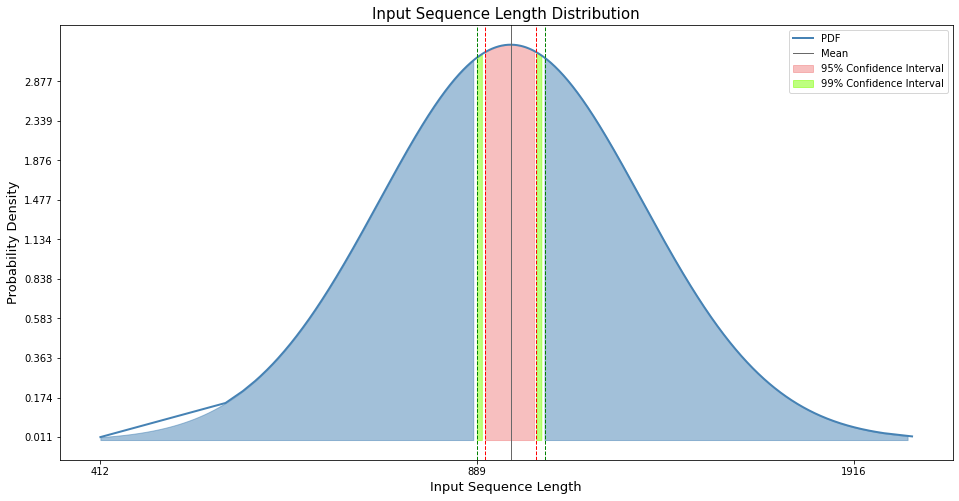

In [116]:
import scipy.stats as stats

plt.rcParams["figure.figsize"] = (16,8)

log_tok_dist = np.log1p(origin_article_token_dist)

log_token_max = np.max(log_tok_dist)
log_token_min = np.min(log_tok_dist)

log_token_var = np.var(log_tok_dist)
log_token_std = np.std(log_tok_dist)
log_token_mean = np.mean(log_tok_dist)

print("Token Distribution : {} ~ {}".format(log_token_min, log_token_max))
print("Token Distribution Mean : {:.3f}\n".format(log_token_mean))
print("Variance : {:.2f} \nStandard Devidation: {:.2f}\n".format(log_token_var, log_token_std))

x = sorted(log_tok_dist)
norm_dist = stats.norm(log_token_mean, log_token_std)

log_L_95 = log_token_mean - 1.96*(log_token_std/np.sqrt(100))
log_U_95 = log_token_mean + 1.96*(log_token_std/np.sqrt(100))
print("95% Confidence Interval : {:.2f} ~ {:.2f}".format(np.expm1(log_L_95), np.expm1(log_U_95)))

log_L_99 = log_token_mean - 2.58*(log_token_std/np.sqrt(100))
log_U_99 = log_token_mean + 2.58*(log_token_std/np.sqrt(100))
print("99% Confidence Interval : {:.2f} ~ {:.2f}".format(np.expm1(log_L_99), np.expm1(log_U_99)))

pdf_line, = plt.plot(x, norm_dist.pdf(x), color='steelblue', linewidth=2)

mean_line = plt.axvline(x=log_token_mean, color='dimgray', linewidth=1)

plt.axvline(log_L_95, color='r', linestyle='--', linewidth=1)
plt.axvline(log_U_95, color='r', linestyle='--', linewidth=1)

plt.axvline(log_L_99, color='g', linestyle='--', linewidth=1)
plt.axvline(log_U_99, color='g', linestyle='--', linewidth=1)

step = 0.01
plt.fill_between(np.arange(log_token_min, log_L_99, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_token_min , log_L_99, step=step)], alpha=0.5, color='steelblue') 

confidence_99_area = plt.fill_between(np.arange(log_L_99 , log_L_95, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_L_99 , log_L_95, step=step)], alpha=0.5, color='chartreuse')

confidence_area = plt.fill_between(np.arange(log_L_95 , log_U_95, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_L_95 , log_U_95, step=step)], alpha=0.5, color='lightcoral')

confidence_99_area = plt.fill_between(np.arange(log_U_95 , log_U_99, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_U_95 , log_U_99, step=step)], alpha=0.5, color='chartreuse')

plt.fill_between(np.arange(log_U_99 , log_token_max, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_U_99 , log_token_max, step=step)], alpha=0.5, color='steelblue') 

x_range = np.arange(log_token_min, log_token_max, step=log_token_max / 10).tolist()
x_range.sort()

plt.title("Input Sequence Length Distribution", fontsize=15)

plt.xticks(x_range, \
           ["{}".format(int(np.expm1(x))) for x in x_range])

y_range = np.arange(np.min(norm_dist.pdf(x)), np.max(norm_dist.pdf(x)), step=np.max(norm_dist.pdf(x)) / 10).tolist()

plt.yticks(y_range, \
           ["{:.3f}".format(np.expm1(y)) for y in y_range])
plt.xlabel('Input Sequence Length', fontsize=13)
plt.ylabel('Probability Density', fontsize=13)

plt.legend(handles=(pdf_line, mean_line, confidence_area, confidence_99_area), 
           labels=('PDF', "Mean", "95% Confidence Interval", "99% Confidence Interval"))


plt.show()